| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font>   |
|:-------------:     |:-----------   |:------  |
| binôme 1  | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span>     |
| binôme 2         | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span>     |




# <center> **Reinforcement Learning by (deep) $Q$-learning** </center>
## <center> Machine Learning Programming Exercise 13</center>






Ce TP concerne la découverte de l'apprentissage par renforcement appliqué au domaine du gaming. Les observations seront données par un émulateur de jeux atari. L'objectif de ce tp est la mise en oeuvre de différents algorithmes de type **$Q$-learning**.

# 1. Import useful packages

## 1.1 Colab or not colab

In [2]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # replace the ipynb_name (below) with the name of your jupyter notebook file

  # ----------- Your code here --------------------->

  # ipynb_name = 'tp_rl_qlearning_startercode_name1_name2.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/**/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

## 1.2 Import common packages

In [3]:
# common imports
import numpy as np

# display imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml') # To get smooth animations



# ML imports
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

elif len(tf.config.list_physical_devices('GPU')) > 1:
  # a décommenter si problème avec le GPU de votre machine
  physical_devices = tf.config.experimental.list_physical_devices('GPU')

  for gpu in physical_devices:
      tf.config.experimental.set_memory_growth(gpu, True)


# RL imports:  install specific packages for openai/gym envs
# install gym
%pip install -q -U gymnasium
%pip install -q -U gymnasium[classic_control]
%pip install pyvirtualdisplay


2024-02-13 15:46:15.090117: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No GPU was detected. CNNs can be very slow without a GPU.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gymnasium[classic_control]
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1.3 Setup

In [4]:
# initialisation des graines aléatoires
SEED = 33
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)


## 1.4 some useful functions

In [5]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# 2.  Processus Markoviens de Décisions (MDP)

Les MDP ont été décrits pour la première fois dans les années 50 par Richard Bellman à partir des chaînes de Markov (développés au début du 20ème siècle par Andrey Markov).


## 2.1 Chaînes de Markov

Les chaînes de Markov sont des processus stochastiques (aléatoires) possédant:
- une nombre d'états fixes
- la possibilité de basculer aléatoirement d'un état à un autre
- la propritée que la probabilité de passage d'un état $s$ à un autre état $s'$ (probabilité de transitions) ne dépend que de l'état courant $s$ (processus sans mémoire, hypothèse de Markov)

Il est facile d'en définir une et de la simuler. Soit la chaîne de Markov suivante:
<table align="center">
<td align="center">
<img src="https://drive.google.com/uc?id=1h6f0H2yOaFAAk53FTX2swG_AsBQ25hnh" height="200px" />
<td/>
</table>

Le code suivant permet de la définir et de la simuler:

In [6]:
# init graine aléatoire
SEED = 33
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Définition des proba de transition par une matrice de la taille**2 de l'espace d'action
transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

N_ITERATIONS = 50

#
def generate_and_print_sequence():

    # initialisation
    current_state = 0 # start from that state
    print("States sequence:", end=" ")

    #
    for step in range(N_ITERATIONS):
        # display
        print(current_state, end=" ")

        # pourquoi?
        if current_state == 3:
            break

        # génération aléatoire de l'état suivant
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()


# call 10 times
for _ in range(10):
    generate_and_print_sequence()


States sequence: 0 0 0 0 0 1 2 1 3 
States sequence: 0 0 0 3 
States sequence: 0 0 0 0 0 3 
States sequence: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States sequence: 0 1 2 1 2 1 2 1 3 
States sequence: 0 0 0 0 1 2 1 2 1 2 1 2 1 2 1 3 
States sequence: 0 0 3 
States sequence: 0 0 0 0 0 3 
States sequence: 0 1 2 1 2 1 2 1 2 1 3 
States sequence: 0 0 0 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


## 2.2 Processus Markoviens de Décisions (MDP)

Les MDP ressemblent aux chaînes de Markov, mais avec une particularité : à chaque étape, un agent peut choisir une des actions possibles, et les probabilités de transition dépendent de l'action choisie. En outre, certaines transitions entre états donnent lieu à une récompense (positive ou négative), et l'objectif de l'agent est de trouver une `policy` qui maximisera les récompenses au fil du temps.

<table align="center">
<td align="center">
<img src="https://drive.google.com/uc?id=1nB13UH5AEjiOZ5b7hCSq3DUl_tmJGd7n" height="300px" />
<td/>
</table>

Par exemple, le MDP représenté dans la figure ci-dessus comporte trois états et jusqu'à trois actions discrètes possibles à chaque étape. Si il commence à l'état $s_0$ , l'agent peut choisir entre les actions $a_0$ , $a_1$ ou $a_2$ . S'il choisit l'action $a_1$ , il reste simplement dans l'état $s_0$ avec certitude et sans aucune récompense. Il peut donc décider d'y rester pour toujours s'il le souhaite. Mais s'il choisit l'action $a_0$ , il a une probabilité de 70% d'obtenir une récompense de +10 et de rester dans l'état $s_0$.

Il peut alors essayer encore et encore d'obtenir le plus de récompense possible. Mais à un moment donné, il finira plutôt dans l'état $s_1$ . Dans l'état $s_1$, il n'a que deux actions possibles : $a_0$ ou $a_1$ . Il peut choisir de rester sur place en choisissant à plusieurs reprises l'action $a_1$ , ou il peut choisir de passer à l'état $s_2$ et obtenir une récompense négative de -50. Dans l'état $s_3$, il n'a pas d'autre choix que de prendre l'action $a_1$, qui le ramènera très probablement à l'état $s_0$ , et obtiendra une récompense de +40 en cours de route.

En examinant ce MDP, pouvez-vous deviner quelle stratégie sera la mieux récompensée au fil du temps ? Dans l'état $s_0$, il est clair que l'action $a_0$ est la meilleure option, et dans l'état $s_3$, l'agent n'a pas d'autre choix que de prendre l'action $a_1$ , mais dans l'état $s_1$, il n'est pas évident que l'agent doive rester sur place ($a_0$) ou passer à travers le feu ($a_2$).

**Question 2.1 (réponse donnée): définissez le MDP via:**
- **les probabilités de transition p(s'|s,a) comme une liste de listes de taille (taille(s),taille(a),taille(s')). Vous mettrez la valeur None si la probabilité n'est pas connue.**
- **les récompenses comme une liste de listes de la même taille**
- **les actions possibles dans chaque état: liste de listes de taille 3**


In [7]:
# ----------- Your code here --------------------->
# transition_probabilities shape=[len(s), len(a), len(s')]
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]

# from state s_0 and taking action a_0, the probabilities to go to state s_0 is 0.7, s_1 is 0.3 and s_2 is 0.0
# from state s_0 and taking action a_1, the probabilities to go to state s_0 is 1.0, s_1 is 0.0 and s_2 is 0.0
# from state s_0 and taking action a_2, the probabilities to go to state s_0 is 0.8, s_1 is 0.2 and s_2 is 0.0
# from state s_1 and taking action a_0, the probabilities to go to state s_0 is 0.0, s_1 is 1.0 and s_2 is 0.0
# from state s_1 and taking action a_1, is not permitted
# and so on

rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]

# from state s_0 and taking action a_0, the rewards associated to the transition to the state s_0 is 10, s_1 is 0 and s_2 is 0
# and so on

# the possible actions from state s_0, s1, s_3
possible_actions = [[0, 1, 2], [0, 2], [1]]

# ------------------------------------------------>
n_actions = len(possible_actions)
n_states = len(transition_probabilities)


# 3. Q-value Iteration algorithm

**Question 3.1: Ecrivez l'algorithme Q-value iteration (cf. slides) permettant de résoudre ce MDP**

In [8]:
# Set the discount factor
GAMMA = 0.90

# Set the max number of iterations
N_ITERATIONS = 50


In [9]:

# Initialize all the Q-values
q_values = np.full((n_states, n_actions), -np.inf) # -np.inf for impossible actions
for state, action in enumerate(possible_actions):
  q_values[state, action] = 0.0  # for all possible actions


# boucle sur les iterations
qiteration_history = [] # sera utilisé dans la suite du tp pour comparer à l'algo du Q-learning
for step in range(N_ITERATIONS):

  # copy to do a one-line update
  q_values_current = q_values.copy()
  qiteration_history.append(q_values_current) # update history

  # boucle sur les états
  for state in range(n_states):

    # boucle sur les actions possibles de l'état s
    for action in possible_actions[state]:
        # q_value iteration update with the Bellman equation :
        tmp = 0.
        for pred_state in range(n_states):

# ----------- Your code here --------------------->

          tmp += transition_probabilities[state][action][pred_state] * (rewards[state][action][pred_state] + GAMMA * np.max(q_values[pred_state]))

# ------------------------------------------------>

        q_values[state, action] = tmp


qiteration_history = np.array(qiteration_history) #


In [10]:
#Vous devez obtenir:
#array([[18.91891892, 17.02702702, 13.62162162],
#       [ 0.        ,        -inf, -4.87971488],
#       [       -inf, 50.13365013,        -inf]])
q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

**Question 3.2: Décrivez et analysez la table des Q_valeurs. Compte tenu du résultat quelle est la policy/stratégie optimale? Analysez la.**

**_`Your commented code below`_**

In [11]:
# ----------- Your code here --------------------->
optimal_policy = np.argmax(q_values, axis=1)

print("Politique optimale :")
for state, action in enumerate(optimal_policy):
    print(f"État {state} : Action optimale {action}")
# ------------------------------------------------>

Politique optimale :
État 0 : Action optimale 0
État 1 : Action optimale 0
État 2 : Action optimale 1


**_`Double cliquez ici pour écrire votre réponse ici!`_**



**Question**: Réessayer avec un discount factor de .95


In [12]:
# Set the discount factor
GAMMA = 0.95

# Set the max number of iterations
N_ITERATIONS = 50 # nb d'iterations


In [13]:

# Initialize all the Q-values
q_values = np.full((n_states, n_actions), -np.inf) # -np.inf for impossible actions
for state, action in enumerate(possible_actions):
  q_values[state, action] = 0.0  # for all possible actions


# boucle sur les iterations
qiteration_history = [] # sera utilisé dans la suite du tp pour comparer à l'algo du Q-learning
for step in range(N_ITERATIONS):

  # copy to do a one-line update
  q_values_current = q_values.copy()
  qiteration_history.append(q_values_current) # update history

  # boucle sur les états
  for state in range(n_states):

    # boucle sur les actions possibles de l'état s
    for action in possible_actions[state]:
        # q_value iteration update with the Bellman equation :
        tmp = 0.
        for pred_state in range(n_states):


# ----------- Your code here --------------------->

          tmp += transition_probabilities[state][action][pred_state] * (rewards[state][action][pred_state] + GAMMA * np.max(q_values[pred_state]))

# ------------------------------------------------>

        q_values[state, action] = tmp


qiteration_history = np.array(qiteration_history) #


In [14]:
q_values

array([[21.79615996, 20.70635196, 16.76923123],
       [ 1.02074831,        -inf,  1.08097586],
       [       -inf, 53.77587186,        -inf]])

In [15]:
optimal_policy = np.argmax(q_values, axis=1)

print("Politique optimale :")
for state, action in enumerate(optimal_policy):
    print(f"État {state} : Action optimale {action}")

Politique optimale :
État 0 : Action optimale 0
État 1 : Action optimale 2
État 2 : Action optimale 1


**Question 3.3**: Donnez et décrivez la signification de $\gamma$
 et analysez la nouvelle table de Q_valeurs. Compte tenu du résultat quelle est la policy/stratégie optimale? Analysez la réponse.

**_`Double cliquez ici pour écrire votre réponse ici!`_**


# 4. Q-Learning algorithm

Le problème du Q-value Iteration algorithm est qu'il faut connaitre parfaitement le modèle de l'environnement (les probabilités de transition).

Nous allons exploiter l'algorithme du $Q$-Learning qui
- suppose que l'agent ne connaît initialement que les états, les actions possibles et les rewards (**interdiction d'utiliser les probabilités de transition**)
- utilise une **politique d'exploration** pour explorer le MDP (**Dans ce cas, on n'utilise pas uniquement la politique pour déterminer l'action**)
- utilise la `difference temporelle` ($TD$ learning) pour estimer $Q^*$ satisfaisant à l'équation d'optimalité de Bellman
- met progressivement à jour les estimations des valeurs $ Q $ en fonction des transitions entre états et des récompenses réellement observées.

L'algorithme que nous allons programmer est dans les slides de cours.


## 4.1 Selection de l'action

Nous avons également besoin d'une stratégie/`policy` d'exploration, qui peut être n'importe quel type de `policy`/stratégie, à condition qu'elle visite tous les états possibles à plusieurs reprises. Nous utiliserons ici une **`policy` purement aléatoire**, puisque l'espace des états est ici très restreint.

**Question 4.1: Nous devons d'abord simuler un agent se déplaçant dans l'environnement, alors définissez une fonction `select_action` permettant t'effectuer une action aléatoire sachant qu'on est dans l'état `state` parmi les action possibles de cet état.**

In [16]:
def select_action(state):

    # choix aléatoire uniforme d'une action possible  à réaliser dans l'état state

# ----------- Your code here --------------------->
    action = np.random.choice(possible_actions[state])
# ------------------------------------------------>

    return action

**TEST**

In [17]:
SEED = 33
tf.random.set_seed(SEED)

print('(false) random action from state 0: {} (expected 0)'.format(select_action(0)))
print('(false) random action from state 1: {} (expected 2)'.format(select_action(1)))
print('(false) random action from state 2: {} (expected 0)'.format(select_action(2)))

(false) random action from state 0: 2 (expected 0)
(false) random action from state 1: 2 (expected 2)
(false) random action from state 2: 1 (expected 0)


## 4.2 Selection de l'état suivant et de la récompense

**Question 4.2: A partir de l'action `action` sélectionnée et de l'état courant `state`  obtenir le nouvel état aléatoirement et la récompense associée**

In [18]:
def select_nextstate_and_reward(state, action):

    # choix aléatoire uniforme du prochain état parmi tous les états possibles

    # ----------- Your code here --------------------->

    next_state = np.random.choice(range(n_states))

    # ------------------------------------------------>


    # lecture de la récompense pour avoir réalisé l'action action dans l'état state
    # et étant passé à l'état next-state

    # ----------- Your code here --------------------->

    reward = rewards[state][action][next_state]
    
    # ------------------------------------------------>

    # sortie
    return int(next_state), int(reward)

**Test**

In [19]:
SEED = 33
tf.random.set_seed(SEED)

for s in range(n_states):
    for a in range(n_actions):
        print('from state {} taking action {}, (next state, reward): {}'.format(s, a, select_nextstate_and_reward(s,a)))


# expected values
# from state 0 taking action 0, (next state, reward): (0, 10)
# from state 0 taking action 1, (next state, reward): (1, 0)
# from state 0 taking action 2, (next state, reward): (1, 0)
# from state 1 taking action 0, (next state, reward): (0, 0)
# from state 1 taking action 1, (next state, reward): (1, 0)
# from state 1 taking action 2, (next state, reward): (1, 0)
# from state 2 taking action 0, (next state, reward): (2, 0)
# from state 2 taking action 1, (next state, reward): (1, 0)
# from state 2 taking action 2, (next state, reward): (2, 0)

from state 0 taking action 0, (next state, reward): (0, 10)
from state 0 taking action 1, (next state, reward): (0, 0)
from state 0 taking action 2, (next state, reward): (2, 0)
from state 1 taking action 0, (next state, reward): (1, 0)
from state 1 taking action 1, (next state, reward): (2, 0)
from state 1 taking action 2, (next state, reward): (2, -50)
from state 2 taking action 0, (next state, reward): (1, 0)
from state 2 taking action 1, (next state, reward): (1, 0)
from state 2 taking action 2, (next state, reward): (0, 0)


## 4.3 Selection de l'état suivant et de la récompense

**Question 4.3:** Ecrivez l'algorithme du $Q$-learning.

In [20]:
# Parametres
N_ITERATIONS = 10000  # nb d'iterations
GAMMA = 0.90 # discount factor
LR_INIT = 0.05 # initial learning rate
LR_DECAY = 0.005 # learning rate decay

# initialisation de la graine
SEED = 33
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [21]:

# initialisation de la matrice des Q-valeurs à zero
q_values = np.full((n_states, n_actions), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    q_values[state][actions] = 0.

# Boucle d'interactions
state = 0 # initial state
qlearning_history = [] # sera utilisé pour comparer à Q_value iteration
for step in range(N_ITERATIONS):

    # update history
    qlearning_history.append(q_values.copy())

# ----------- Your code here --------------------->

    # select random action
    action = select_action(state)

    # select next state and reward
    next_state, reward = select_nextstate_and_reward(state, action)

# ------------------------------------------------>




    # le learning rate décroit avec le nombre d'iteration
    learning_rate = LR_INIT / (1 + step * LR_DECAY)




# ----------- Your code here --------------------->

    # calcul de la TD target pour Q
    td_target = reward + GAMMA * np.max(q_values[next_state])

    # mise à jour la matrice de Q_values
    q_values[state, action] += learning_rate * (td_target - q_values[state, action])
    
# ----------- Your code here --------------------->

    # mise à jour de l'état courant
    state = next_state

qlearning_history = np.array(qlearning_history)

In [22]:
# Test: array([[26.1907234 , 23.29105121, 23.3312448 ],
#        [24.42046691,        -inf,  7.64111659],
#        [       -inf, 39.38499652,        -inf]])
q_values

array([[23.75299624, 20.76395075, 20.55746671],
       [22.4674815 ,        -inf,  5.51371645],
       [       -inf, 37.04074971,        -inf]])

**Question 4.4:** Quelle est la policy optimale?

In [23]:
# ----------- Your code here --------------------->

optimal_policy = np.argmax(q_values, axis=1)

print("Politique optimale :")
for state, action in enumerate(optimal_policy):
    print(f"État {state} : Action optimale {action}")

# ------------------------------------------------>

Politique optimale :
État 0 : Action optimale 0
État 1 : Action optimale 0
État 2 : Action optimale 1



**Grâce au code fourni, vous pouvez visualiser la vitesse de convergence des deux algorithmes et voir l'influence de ne pas connaître les probabilités de transition pour le Q-learning.**


(0.0, 10000.0, 0.0, 100.0)

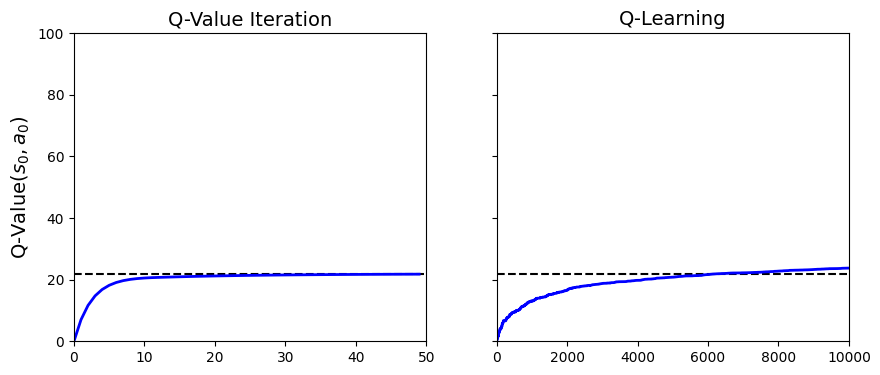

In [24]:
true_Q_value = qiteration_history[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

n = qiteration_history.shape[0]
axes[0].plot([0, n], [true_Q_value, true_Q_value], "k--")
axes[0].plot(np.arange(n), qiteration_history[:, 0, 0], "b-", linewidth=2)
axes[0].axis([0, n, 0, 100])

n = qlearning_history.shape[0]
axes[1].plot([0, n], [true_Q_value, true_Q_value], "k--")
axes[1].plot(np.arange(n), qlearning_history[:, 0, 0], "b-", linewidth=2)
axes[1].axis([0, n, 0, 100])


# 5. Introduction to OpenAI gym (facultatif si vous l'avez déjà fait)

C'est le même que dans le tp sur les algorithmes `policy gradient`. Si vous l'avez déjà fait, passez directement à la section suivante.



Dans ce notebook, l'environnement et les observations/données seront fournis par le framework [OpenAI gym](https://gym.openai.com/). Il fournit de nombreux environnements avec lesquels peut interagir et apprendre votre *agents*.
L'import se fait classiquement par:

In [25]:
import gymnasium as gym
gym.__version__

'0.29.1'

La liste des environnements disponibles est donnée par:

In [26]:
g = gym.envs.registry
for l in list(g):
  print(l)



CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV21Environment-v0
GymV26Environment-v0


## 5.1 Le Cart-Pole

Le Cart-Pole est un environnement très simple dans lequel un chariot peut bouger soit vers la gauche, soit vers la droite. Un bâton/piquet est placé sur ce dernier. L'agent doit alors bouger le chariot à gauche ou à droite pour que le bâton reste droit.
<table align="center">
<td align="center">
<img src="https://drive.google.com/uc?id=1RNWq3McGaTydH2PrNQWFcXLxV7Lg2mC8" height="300px" />
<td/>
</table>


L'environnement est défini par la commande make():


In [27]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

Il faut ensuite initialiser l'environnement en appelant la méthode `reset()` qui retourne la première observation.

In [28]:
SEED = 33
obs = env.reset(seed=SEED)
obs

(array([-0.00563578,  0.00684912,  0.04081038, -0.02457505], dtype=float32),
 {})

Les observations dépendent de l'environnement considéré. Dans ce cas, les observations sont regroupées dans un array Numpy 1D soit 1 vecteur composé de 4 floats. Ce vecteur regroupe:
- la position horizontale du chariot (<0 gauche; 0 = verticale; >0 droite)
- la vitesse du chariot  
- l'angle du bâton (<0 gauche; 0 = verticale; >0 droite)
- la vitesse angulaire


Un environnement peut-être visualisé par appel à la méthode `render()`. Pour récupérer une observation (une image) de l'environnement sous la forme d'un array NumPy:

In [29]:
img = env.render()
img.shape

(400, 600, 3)

La fonction plot_environment() permet de récupérer et d'afficher l'observation courante de l'environnement.


In [30]:
def plot_environment(env, figsize=(5,4)):
    # get an observation
    img = env.render()

    # display an observation
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    return img

Pour interagir avec l'environnement, l'agent doit sélectionner une action à partir de l'espace des actions possibles. Pour chaque environnement, la commande `action_space` permet de connaitre cet espace.

In [31]:
env.action_space

Discrete(2)

Pour le cartpole,deux actions sont possible: gauche ou droite.

Dans l'état actuel, le bâton est penché vers la droite (`obs[2] > 0`); passons l'action de déplacer le chariot vers la droite.

In [32]:
# action
go_right = True  # or 1, go right
go_right = False # or 0, go right

# interaction with the environment
obs, reward, done, truncated, info = env.step(go_right)

# observation
obs

array([-0.00549879, -0.18883361,  0.04031888,  0.28069958], dtype=float32)

Remarquez que:
- le chariot se déplace maintenant vers la droite (`obs[1] > 0`);
- le bâton est toujours incliné vers la droite (`obs[2] > 0`) ;
- mais sa vitesse angulaire est maintenant négative (`obs[3] < 0`), il est ainsi vraissemblable qu'il soit incliné vers la gauche après la prochaine action.

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

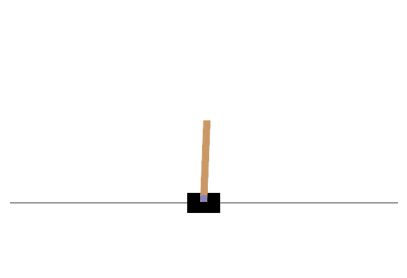

In [33]:
plot_environment(env)

L'interaction avec l'environnement:
- génère l'observation suivante `obs`
- renseigne l'agent sur la récompense générée par l'action prise: `reward`
- retourne `done=True` si le jeu est fini (pour cet environnement, le jeu est fini si l'angle du baton est de plus de 12° ou si le chariot s'est déplacé de plus 2.4 unités par rapport au centre.)
- `truncated`: cette valeur sera True lorsqu'un épisode est interrompu prématurément, par exemple par un wrapper d'environnement qui impose un nombre maximum d'étapes par épisode (voir la documentation de Gym pour plus de détails sur les wrappers d'environnement).
- info est un dictionnaire spécifique à chaque environnement qui peut contenir des informations supplémentaires pour le debugging ou l'apprentissage.

In [34]:
print(reward, done, truncated)

1.0 False False


Comme nous l'avons vu en cours, un **épisode** correspond à la séquence d'interactions entre le moment où l'environnement est lancé `reset()` et le moment ou `done=True`. Pour relancer un épisode, il faut refaire appel à la méthode `reset()`.

In [35]:
if done or truncated:
    obs = env.reset()

# 6. Définition d'une politique simple (policy)

Revenons au **CartPole** et essayons de maintenir le bâton droit. Nous avons besoin d'une policy (politique/stratégie) pour cela. Il s'agit d'une stratégie que l'agent utilisera pour sélectionner une action à chaque étape. Cette stratégie pourra potentiellement utiliser toutes les actions et observations passées pour faire cela.

Pour le moment, nous allons définir une politique très simple consistant à déplacer le chariot vers la gauche (resp. la droite) quand il penche vers la gauche (resp. la droite). Ici, la policy $\pi_{\theta}(\mathbf{a}_t|\mathbf{o}_t)$ est déterministe pourra donc s'écrire $\mathbf{a}_t = \pi(\mathbf{o}_t)$.

**Question 6.1: Pour l'implémentation vous créerez:**
- **une fonction `select_action_simple_policy(obs)` retournant l'action à prendre en fonction de l'observation**
- **un script qui permet de**
 - **générer `N_EPISODES` (500) **épisodes** (ou **trajectoires**, **roll_out**)**
 - **chacun de ces épisodes comprend un nombre max d'interactions (de pas temporels) avec l'environnement fixé à `N_STEPS_MAX_PER_EPISODE = 200`**
 - **pour chaque interaction (pas temporel), décider de l'action à prendre (appel à `select_action_simple_policy()`), jouer cette action en interagissant avec l'environnement et récupérer la récompense et calculer la récompense totale**
 - **calculer les performances de l'algorithme (les statistiques: moyenne, std, min, max)**


**Notes**: deux boucles imbriquées sont à coder, vous pouvez suivre le squellette suivant


In [43]:
# policy definition
def select_action_simple_policy(obs):

# ----------- Your code here --------------------->

    if obs[2] > 0:
        go_right = True
    else:
        go_right = False
        
# ------------------------------------------------>
    return go_right


In [44]:
# init
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode="rgb_array")

# set random seed
SEED = 33

tf.random.set_seed(SEED)
np.random.seed(SEED)
obs = env.reset(seed=SEED)



# parameters
N_EPISODES = 500
N_STEPS_MAX_PER_EPISODE = 200




In [47]:





# boucle sur les épisodes/loop over the episodes
episode_cumrewards_history=[]
for episode in range(N_EPISODES):

    # starting a new episode
    episode_cumrewards = 0
    obs, info = env.reset(seed=episode)

    # ...with N_STEPS_MAX_PER_EPISODE interactions (temps)
    for step in range(N_STEPS_MAX_PER_EPISODE):

# ----------- Your code here --------------------->

      # starting a new interaction

      # select an action
      go_right = select_action_simple_policy(obs)

      # interaction with the environment
      obs, reward, done, truncated, info = env.step(int(go_right))

      # compute cumulative reward
      episode_cumrewards += reward

# ------------------------------------------------>

      # continue or not
      if done or truncated:
        print('break at {}: done={},  truncated={}'.format(step, done, truncated))
        break

    # performance statistics
    episode_cumrewards_history.append(episode_cumrewards)

break at 40: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 34: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 31: done=True,  truncated=False
break at 33: done=True,  truncated=False
break at 44: done=True,  truncated=False
break at 47: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 42: done=True,  truncated=False
break at 48: done=True,  truncated=False
break at 51: done=True,  truncated=False
break at 34: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 36: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 39: done=True,  truncated=False
break at 44: don

**Question 6.2: Affichez:**
- **la récompense cumulée moyenne +/- écart type calculée sur les épisodes**
- **l'évolution de la récompense cumulée au cours des épisodes**


**_`Your commented code below`_**

Récompense cumulée moyenne: 41.698 +/- 8.389445512070509


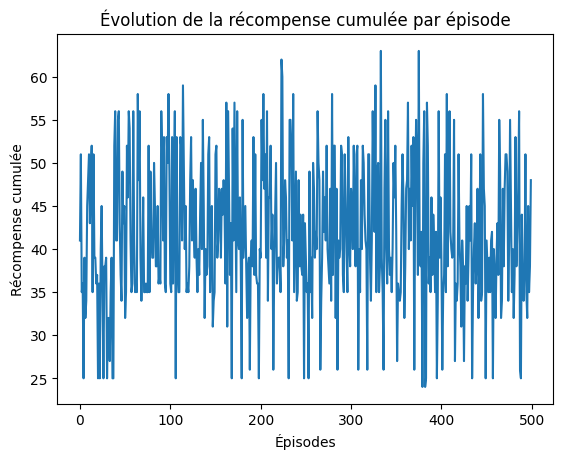

In [48]:
# ----------- Your code here --------------------->
mean_reward = np.mean(episode_cumrewards_history)
std_reward = np.std(episode_cumrewards_history)

print(f"Récompense cumulée moyenne: {mean_reward} +/- {std_reward}")

plt.plot(episode_cumrewards_history)
plt.title("Évolution de la récompense cumulée par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.show()

# ------------------------------------------------>

# expected value 41.698 +/- 8.389445512070509


**Questions 6.3**: Quelles sont vos conclusions sur les performances obtenues?


**_`Double cliquez ici pour écrire votre réponse ici!`_**

<FONT COLOR="#ff0000">

**Solution**
Comme on pouvait s'y attendre, cette stratégie est un peu trop basique : le mieux qu'elle ait fait est de maintenir l'interrogation pendant seulement 66 étapes. Cet environnement est considéré comme résolu lorsque l'agent maintient le sondage pendant 200 étapes.
</FONT>




Vous pouvez visualiser l'évolution du cartpole au cours d'un episode avec la boucle suivante.

**Question 6.4: Complétez les lignes demandées.**

In [58]:
# init
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode="rgb_array")

# set random seed
SEED = 33

tf.random.set_seed(SEED)
np.random.seed(SEED)
obs, info = env.reset(seed=SEED)

# boucle temporelle d'interactions, un step = un pas temporel = une interaction
frames = []
for step in range(N_STEPS_MAX_PER_EPISODE):

    # recuperation de l'environnement courant
    img = env.render()
    frames.append(img)

# ----------- Your code here --------------------->
    # selectionner une action
    go_right = select_action_simple_policy(obs)
# ------------------------------------------------>

# ----------- Your code here --------------------->
    # interaction avec l'environnement
    obs, reward, done, truncated, info = env.step(int(go_right))
# ------------------------------------------------>

    # continue or not
    if done or truncated:
        print('break at {}: done={},  truncated={}'.format(step, done, truncated))
        break


break at 26: done=True,  truncated=False


Vous pouvez définir un lecteur d'animation.

In [59]:
plot_animation(frames)

# 8. Deep Q-Network et Deep Q-Learning

Le principal problème du $Q$-Learning est qu'il n'est pas bien adapté aux MDP ayant un grand (ou même moyen) nombre d'états et actions (sans parler des cas où les états et les actions sont continues) car la matrice des Q-valeurs devient trop grande.

La solution consiste à trouver une fonction qui approxime les $Q$-valeurs en utilisant une nombre de paramètres peu important. Pendant des années, il était recommandé d'utiliser des combinaisons linéaires de features extraits des états ou observations (par exemple, la distance des fantômes les plus proches, leurs directions, etc. dans le jeu Pacman) pour estimer les $Q$-valeurs, mais DeepMind a montré que l'utilisation de réseaux de neurones profonds fonctionne beaucoup mieux, en particulier pour les problèmes complexes, et cela ne nécessite aucune extraction *manuelle* de features. Un réseau de neurones utilisé pour estimer les $Q$-valeurs est appelé **deep $Q$-Network** (DQN), et l'utilisation d'un DQN pour l'approximation des $Q$-valeurs est appelée **Deep Q-Learning**.

Ici nous allons appliquer cet algorithme au cas du cartpole (même si ici le nombre d'états et d'actions sont restreints).

## 8.1 Création d'un réseau de neurones pour la q_values

Pour résoudre l’environnement CartPole, nous n’avons pas besoin d’un réseau très complexe ; deux couches cachées suffisent.

**Question 8.1: Définissez un réseau de neurones:**
- **à 2 couches cachées dense de 32 neurones utilisant des fonctions d'activation `elu`**
- **avec en entrée les états de l'environnement**
- **et en sortie les actions possibles dans l'environnement.**

**Que représentent les sorties de ce réseau?**

In [63]:
# init
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode="rgb_array")
tf.keras.backend.clear_session()

# set random seed
SEED = 33

# initialisation des graines
tf.random.set_seed(SEED)
np.random.seed(SEED)
obs, info = env.reset(seed=SEED)
tf.keras.utils.set_random_seed(SEED)

# ----------- Your code here --------------------->

qvalues_model= tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='elu', input_shape=(4,)), 
    tf.keras.layers.Dense(32, activation='elu'), 
    tf.keras.layers.Dense(2) 
])

# ------------------------------------------------>


# test du model
q = qvalues_model(obs[np.newaxis])
print(q)

# tf.Tensor([[-0.00106677  0.00520632]], shape=(1, 2), dtype=float32)


tf.Tensor([[0.00353857 0.00696758]], shape=(1, 2), dtype=float32)


**_`Double cliquez ici pour écrire votre réponse ici!`_**


## 8.2 Sélectionner une action selon une stratégie exploitation/exploration


Nous allons sélectionner une action à l'aide de ce DQN selon une stratégie d'exploration appelée $\epsilon$**-greedy policy** (elle est décrite dans mes slides). Pour la mettre en oeuvre, répondez aux questions suivantes.



**Question 8.2: comment choisir l'action à partir `qvalues_model`**


**_`Double cliquez ici pour écrire votre réponse ici!


**Question 8.3: comment fonctionne l'algorithme $\mathbf{\epsilon}$-greedy policy?**


**_`Double cliquez ici pour écrire votre réponse ici!




**Mettez-la en oeuvre ici:**

In [64]:
def select_action_epsilon_greedy_policy(state, epsilon=0):

    if np.random.rand() < epsilon: # epsilon #tf rand?

# ----------- Your code here --------------------->

        action = np.random.randint(2)

# ------------------------------------------------>

    else: # greedy
# ----------- Your code here --------------------->

        q_values = qvalues_model.predict(state[np.newaxis]) 
        action = np.argmax(q_values)

# ------------------------------------------------>

    action  = int(action)

    return action


## 8.3 Experience replay buffer

Deep Q-learning est un algorithme `off-policy` (cf slides de cours pour la différence entre `on/off policy`).


Au lieu d’entraîner le DQN en fonction des dernières expériences uniquement, nous stockons toutes les expériences dans une mémoire (experience replay buffer ) et nous en extrayons un batch aléatoire à chaque itération d’entraînement. Cela permet de réduire les corrélations entre les expériences d’un batch d'entraînement et facilite énormément cette étape d'apprentissage.

Ces expériences passées de l'agent (Experience replay) seront stockée sous forme de tuples : `(obs, action, récompense, next_obs, done)`. Nous pouvons utiliser la classe `deque` pour effectuer cela. Un deque est une liste chaînée dans laquelle chaque élément pointe sur le suivant et sur le précédent.  L’insertion et la suppression des éléments sont très rapides, mais plus la liste deque est longue, plus l’accès aléatoire est lent.

In [65]:
from collections import deque

replay_buffer = deque(maxlen=2000)

Chaque expérience est constituée de cinq éléments : un état, l’action effectuée par l’agent, la récompense résultante, l’état suivant atteint et une valeur booléenne indiquant si l’épisode est à ce stade terminé (done). Nous avons besoin d’une petite fonction d’échantillonnage d’un lot aléatoire d’expériences à partir du replay buffer.

Et créons une fonction pour sélectionner aléatoirement les expériences de la mémoire pour former un mini-batch  de données. Elle renverra 5 tableaux NumPy de taille batch_size: `[obs, actions, récompenses, next_obs, dones]`.
A noter que des variantes existent pour sélectionner stratégiquement des expériences significatives.

In [66]:
def select_batch_from_replay_buffer(batch_size):

    # selection aléatoire dans la mémoire
    indices = np.random.randint(len(replay_buffer), size=batch_size)

    # mise en liste
    batch = [replay_buffer[index] for index in indices]

    # mise en numpy arrays du batch
    states, actions, rewards, next_states, dones, truncateds = [np.array([experience[field_index] for experience in batch]) for field_index in range(6)]

    # sortie
    return states, actions, rewards, next_states, dones, truncateds

## 8.4 Générer les données pour une interaction (un pas temporel)


Nous pouvons maintenant créer une fonction qu'utilisera le DQN pour :
- selectionner une action selon une stratégie d'exploration/exploitation
- interagir avec l'environnement (un pas temporel)
- et enregistrer son expérience dans la mémoire buffer.

**Question 8.4: Compléter la fonction `run_one_step`.**

In [69]:
def run_one_step(env, state, epsilon):


    # selection d'une action à partir de l'état
# ----------- Your code here --------------------->

    action = select_action_epsilon_greedy_policy(state, epsilon)

# ------------------------------------------------>




    # interaction avec l'environment
# ----------- Your code here --------------------->

    next_state, reward, done, truncated, info = env.step(action)
# ------------------------------------------------>



    # update replay buffer with state, action, reward, next_state, done, truncated
    replay_buffer.append((state, action, reward, next_state, done, truncated))

    # output
    return next_state, reward, done, truncated, info

**Test**

In [70]:
# init
# import gymnasium as gym
env = gym.make('CartPole-v1', render_mode="rgb_array")
tf.keras.backend.clear_session()

# set random seed
SEED = 33

tf.random.set_seed(SEED)
np.random.seed(SEED)
obs, info = env.reset(seed=SEED)

# test
state = 0
epsilon = .5
next_state, reward, done, truncated, info = run_one_step(env, state, epsilon)
print(next_state, reward, done, truncated, info)
# [-0.00549879 -0.18883361  0.04031888  0.28069958] 1.0 False False {}

[-0.00549879 -0.18883361  0.04031888  0.28069958] 1.0 False False {}


## 8.5 Apprentissage de l'algorithme deep Q-learning

Enfin, nous allons créer une fonction qui va effectuer une étape d'entraînement par descente de gradient.

### 8.5.1 Paramètres


In [71]:
# initialisation des paramètres et de l'optimiseur et de la fonction de coût
N_EPISODES              = 600 #
N_STEPS_MAX_PER_EPISODE = 200
BATCH_SIZE              = 32
DISCOUNT_FACTOR         = 0.95
LEARNING_RATE           = 1e-2

SEED                    = 33




### 8.5.2. Définir le modèle DQN approximant les Q-values

In [72]:
# ----------------------------------->
# Definition of the Q-values neural network
# ----------------------------------->


# ----------- Your code here --------------------->

qvalues_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(4,)), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2) 
])

# ------------------------------------------------>


### 8.5.2  Choisir la tâche à apprendre et comment la résoudre


In [73]:
# Choix de la fonction de cout

# ----------- Your code here --------------------->

loss_fcn = tf.keras.losses.binary_crossentropy

# -------- END YOUR CODE HERE --------->

# Choix de l'optimiseur
optimizer_fcn = tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE)


### 8.5.3 Apprentissage du DQN sur un batch d'expériences

**Question 8.5: compléter le code ci-dessous**

In [74]:

# fonction réalisant un pas d'apprentissage
def train_dqn_on_batch(batch_size):


    # former le batch d'expériences (experience replay)
# ----------- Your code here --------------------->

    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

# ------------------------------------------------>





    # Predire les q-valeurs les prochains états
# ----------- Your code here --------------------->

    next_q_values = qvalues_model.predict(next_states)

# ------------------------------------------------>


    # calcul du max sur les actions des q-valeurs des prochains états
# ----------- Your code here --------------------->

    max_next_q_values = np.max(next_q_values, axis=1)

# ------------------------------------------------>




    # Calculer la q_target ou TD target pour les q-valeurs
# ----------- Your code here --------------------->

    target_q_values = rewards + (1 - dones) * discount_factor * max_next_q_values
    
# ------------------------------------------------>

    # mise en forme
    target_q_values = tf.reshape(target_q_values, (-1, 1)) # (batch_size,)
    # print('target_q_values',target_q_values)

    # encodage des actions en one-hot encoding (format pris par la loss function)
    mask = tf.one_hot(actions, n_outputs)
    # print('mask',mask)

    # Calcul de la fonction de cout dans le contexte GradientTape
    with tf.GradientTape() as tape:

        # forward pass of the model to estimate the Q_values
        q_values = qvalues_model(states)

        # calcul de la loss (à noter qu'on sélectionne uniquement les valeurs non nulles grâce au mask)
        q_values = tf.reduce_sum(q_values * mask, axis=1, keepdims=True)

        # calcul de la loss
        loss = tf.reduce_mean(loss_fcn(target_q_values, q_values))


    # Estimation des gradients de la fonction de cout
    grads = tape.gradient(loss, qvalues_model.trainable_variables)

    # Update par descente de gradient
    optimizer_fcn.apply_gradients(zip(grads, qvalues_model.trainable_variables))

    return loss, grads

### 8.5.4. Script final d'apprentissage DQN

Finalement, on a tous les blocs pour l'algorithme final que vous compléterez (prenez les bouts de code plus haut si besoin).

In [75]:
# ----------------------------------->
# Création de l'environnement de simulation
# ----------------------------------->
env = gym.make('CartPole-v1', render_mode="rgb_array")

# initialisation des graines aléatoires
obs = env.reset(seed=SEED)
np.random.seed(SEED)
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)



In [77]:

episodes_reward = []
episodes_loss = []

best_score = 0
for episode in range(N_EPISODES):

    # init de l'environnement
    step_obs, step_info = env.reset()

    # génération de données en interagissant avec l'environnement
    # le buffer se remplit...
    for step in range(N_STEPS_MAX_PER_EPISODE):

        # stratégie d'exploration: les valeurs d'epsilon s'étalent linéairement de 1 à 0.001
        epsilon = max(1 - episode / 500, 0.01)

        # Générer les données pour une interaction (un pas temporel)
# ----------- Your code here --------------------->

        step_obs, step_reward, step_done, step_truncated, step_info = run_one_step(env, step_obs, epsilon)
        
# ------------------------------------------------>

        if step_done or step_truncated:
            break


    # update rewards obtained
    episodes_reward.append(step) #
    print("\rEpisode: {}, Rewards: {}, Best Rewards: {}, eps: {:.3f}".format(episode, step + 1, best_score + 1, epsilon), end="")


    # performance: pour cart-pole plus step est grand plus le score est bon
    if step > best_score: #
        best_weights = qvalues_model.get_weights() #
        best_score = step #


    # une fois le buffer suffisamment rempli, on peut commencer à sélectionner et entrainer sur des batchs
    if episode > 50:
# ----------- Your code here --------------------->

      loss, _ = train_dqn_on_batch(batch_size)

# ------------------------------------------------>
        
      episodes_loss.append(loss) #

    else:
      episodes_loss.append([])




# Eventually, update qvalues_model with best_weights
qvalues_model.set_weights(best_weights)

Episode: 2, Rewards: 16, Best Rewards: 30, eps: 0.996

NameError: name 'q_values_network' is not defined

**Question: examinez et commentez les récompenses obtenues tout au long de l'apprentissage**

In [ ]:
# ----------- Your code here --------------------->

# ------------------------------------------------>


Double-cliquez pour donner votre réponse


### 8.5.5. Test de la Q-value apprise

**Question 6.5: complétez enfin ce code permettant de tester la Q-value apprise**



**Attention!! pas d'exploration en mode test!**

In [ ]:
# parametres
N_STEPS_MAX_PER_EPISODE = 200



In [ ]:
# ----------------------------------->
# test de la Q-value apprise
# ----------------------------------->

# initialisation de l'environnement
env = gym.make('CartPole-v1', render_mode="rgb_array")

# on fixe la graine aléatoire
# env.seed(SEED)

# recupération de la première obs/state
state, info = env.reset(seed=SEED)


# boucles de N_STEPS_MAX_PER_EPISODE interactions max
frames = []
steps_rewards = []
for step in range(N_STEPS_MAX_PER_EPISODE):

  # recuperation de l'environnement courant
  frames.append(env.render())

  # selection d'une action à partir de l'état
# ----------- Your code here --------------------->


  # action=...

# ------------------------------------------------>

  # interaction avec l'environnement
# ----------- Your code here --------------------->

  # state,...

# ------------------------------------------------>

    # mise à jour de la liste des rewards
  steps_rewards.append(reward)

  # break or not
  if done:
    break



plt.figure(figsize=(8, 4))
# plt.plot(np.arange(len(rewards)), np.array(steps_rewards))
plt.plot(np.array(steps_rewards))
plt.xlabel("step []", fontsize=14)
plt.ylabel("Reward []", fontsize=14)
plt.show()




In [ ]:
plot_animation(frames)
